<a href="https://www.kaggle.com/code/nassifelski/random-forest-and-gb-for-travel-insurance?scriptVersionId=163843891" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
import warnings
warnings.filterwarnings("ignore")

/kaggle/input/travel-insurance-prediction-data/TravelInsurancePrediction.csv


In [2]:
#Reading the data
df = pd.read_csv("/kaggle/input/travel-insurance-prediction-data/TravelInsurancePrediction.csv")

In [3]:
df.head()

,Unnamed: 0,Age,Employment Type,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance
0,0,31,Government Sector,Yes,400000,6,1,No,No,0
1,1,31,Private Sector/Self Employed,Yes,1250000,7,0,No,No,0
2,2,34,Private Sector/Self Employed,Yes,500000,4,1,No,No,1
3,3,28,Private Sector/Self Employed,Yes,700000,3,1,No,No,0
4,4,28,Private Sector/Self Employed,Yes,700000,8,1,Yes,No,0


Let's start with a EDA

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1987 entries, 0 to 1986
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Unnamed: 0           1987 non-null   int64 
 1   Age                  1987 non-null   int64 
 2   Employment Type      1987 non-null   object
 3   GraduateOrNot        1987 non-null   object
 4   AnnualIncome         1987 non-null   int64 
 5   FamilyMembers        1987 non-null   int64 
 6   ChronicDiseases      1987 non-null   int64 
 7   FrequentFlyer        1987 non-null   object
 8   EverTravelledAbroad  1987 non-null   object
 9   TravelInsurance      1987 non-null   int64 
dtypes: int64(6), object(4)
memory usage: 155.4+ KB


There is no missing value in the data set. 

In [5]:
#Let's check the different values for the columns consisitng of Yes and No values
print(df["GraduateOrNot"].value_counts())
print(df["FrequentFlyer"].value_counts())
print(df["EverTravelledAbroad"].value_counts())

GraduateOrNot
Yes    1692
No      295
Name: count, dtype: int64
FrequentFlyer
No     1570
Yes     417
Name: count, dtype: int64
EverTravelledAbroad
No     1607
Yes     380
Name: count, dtype: int64


In [6]:
#Now lets replace the Yes and No values by 1 and 0 respectively 
df["GraduateOrNot"].replace({"Yes":1,"No":0},inplace=True)
df["FrequentFlyer"].replace({"Yes":1,"No":0},inplace=True)
df["EverTravelledAbroad"].replace({"Yes":1,"No":0},inplace=True)

In [7]:
#Now let's create some dummies for the Employment Type column and replace the column 
EmploymentType=pd.get_dummies(df["Employment Type"]).astype(int)
df=pd.concat([df,EmploymentType],axis=1) #join the dummie variables to df
df.drop("Employment Type",axis=1,inplace=True) #...now drop the initial Employment Type column

In [8]:
#Drop the unnamed column
df.drop("Unnamed: 0",axis=1,inplace=True)

In [9]:
df.head()

,Age,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance,Government Sector,Private Sector/Self Employed
0,31,1,400000,6,1,0,0,0,1,0
1,31,1,1250000,7,0,0,0,0,0,1
2,34,1,500000,4,1,0,0,1,0,1
3,28,1,700000,3,1,0,0,0,0,1
4,28,1,700000,8,1,1,0,0,0,1


Now let's visualize the data. 

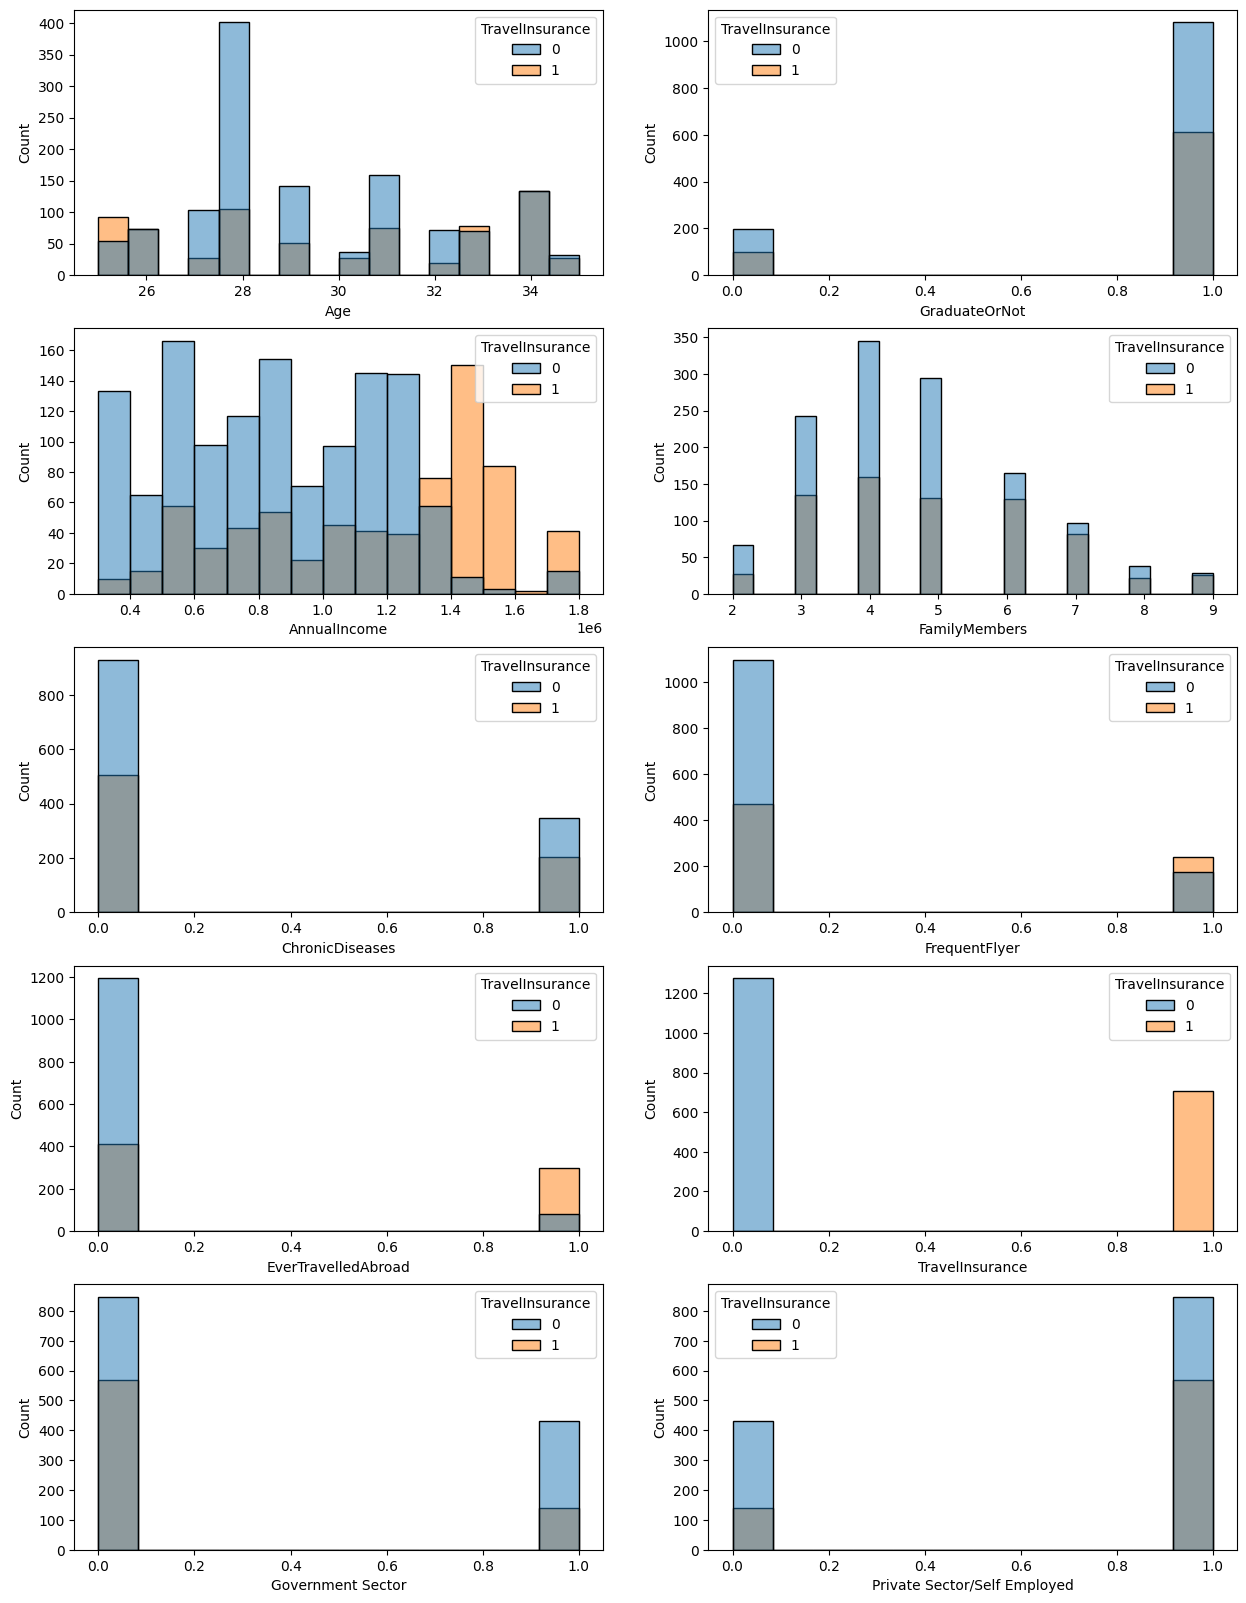

In [10]:
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(15,20))
axs=axs.flat
for i in range (len(df.columns)):
    sns.histplot(data=df, x=df.columns[i],ax=axs[i],hue="TravelInsurance")
plt.show()    

<Axes: >

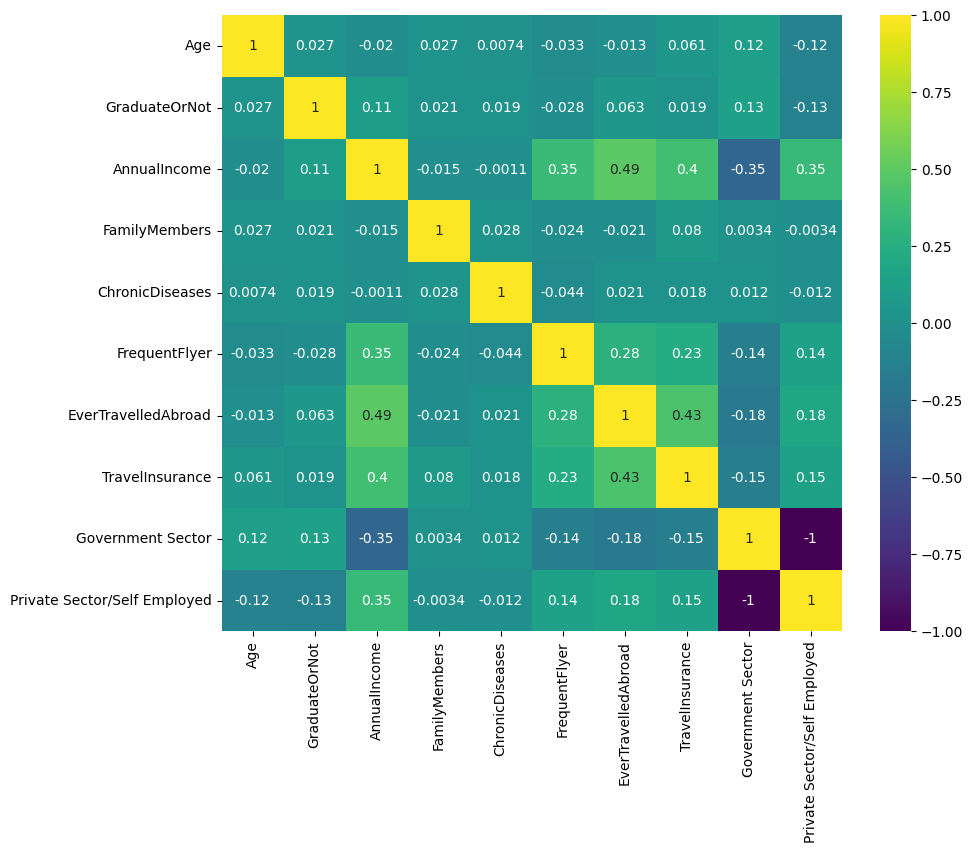

In [11]:
#Let's take a deeper look on the correlation
corr=df.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr,annot=True,cmap='viridis')

Our target value is "TravelInsurance". Therefore let's plot the correlation of each feature against the target as well


<Axes: >

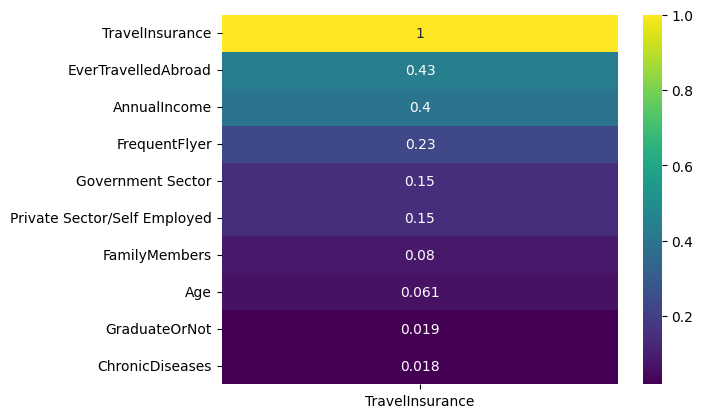

In [12]:
corr=df.corr()["TravelInsurance"]
corr=corr.abs().sort_values(ascending=False).to_frame()
sns.heatmap(data=corr,annot=True, cmap='viridis')

**Models: Random Forest & Gradient Boosting**
In the next chapter I will build two models, Random Forest & Gradient Boosting and measure their performance. Both models will by optimized by Hyperparameter tuning via grid search

In [13]:
#First let's get our Input matrix X and output vector y
X=df.drop("TravelInsurance",axis=1).to_numpy()
y=df["TravelInsurance"].to_numpy()

In [14]:
#Since the "Age" and "AnnualIncome" values are of higher dimension, I will scale X, using Standard Scaler.
scaler=StandardScaler()
X_scaled=scaler.fit_transform(X)

In [15]:
#Split data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

**1. Random Forest Classifier**

In [16]:
randomforest=RandomForestClassifier(random_state=42)
randomforest.fit(X_train,y_train)
y_pred=randomforest.predict(X_test)

In [17]:
print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred))

[[235  22]
 [ 50  91]]
0.8190954773869347


In [18]:
#Now let's optimize the random forest, using grid search:
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None,5, 10, 20, 30],
    'min_samples_split': [2, 5, 10,15,20],
    'min_samples_leaf': [1, 2,3, 4,5]
}


In [19]:
rf_classifier=RandomForestClassifier()
random_search = RandomizedSearchCV(rf_classifier, param_distributions=param_grid, n_iter=10, cv=5, random_state=42)
random_search.fit(X_train,y_train)


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(),
                   param_distributions={'max_depth': [None, 5, 10, 20, 30],
                                        'min_samples_leaf': [1, 2, 3, 4, 5],
                                        'min_samples_split': [2, 5, 10, 15, 20],
                                        'n_estimators': [10, 50, 100, 200]},
                   random_state=42)

In [20]:
random_search.best_estimator_

RandomForestClassifier(min_samples_leaf=4, min_samples_split=15,
                       n_estimators=50)

In [21]:
rf_model=RandomForestClassifier(random_state=42,max_depth=30, min_samples_leaf=3,min_samples_split=10)
rf_model.fit(X_train,y_train)
y_rf=rf_model.predict(X_test)

In [22]:
print(confusion_matrix(y_test,y_rf))
print(accuracy_score(y_test,y_rf))

[[255   2]
 [ 61  80]]
0.8417085427135679


In [23]:
#The accuracy has improved. Let's print a classification report for the optimized Random Forest Classifier
print(classification_report(y_test,y_rf))

              precision    recall  f1-score   support

           0       0.81      0.99      0.89       257
           1       0.98      0.57      0.72       141

    accuracy                           0.84       398
   macro avg       0.89      0.78      0.80       398
weighted avg       0.87      0.84      0.83       398



**2. Gradient Boosting**

In [24]:
from sklearn.ensemble import GradientBoostingClassifier
gb_classifier = GradientBoostingClassifier()

In [25]:
param_grid2 = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.05,0.1,0.2,0.5, 1.0],
    'max_depth': [3,4, 5,10],
    'min_samples_split': [3, 5, 7,10,15],
    'min_samples_leaf': [1, 2, 3,4]
}

In [26]:
grid_search2 = RandomizedSearchCV(gb_classifier, param_distributions=param_grid2, cv=5,random_state=42)

# Fit the model to the data
grid_search2.fit(X_train, y_train)

# Print the best parameters and the corresponding accuracy
print("Best Parameters: ", grid_search2.best_params_)
print("Best Accuracy: ", grid_search2.best_score_)

Best Parameters:  {'n_estimators': 50, 'min_samples_split': 15, 'min_samples_leaf': 2, 'max_depth': 4, 'learning_rate': 0.05}
Best Accuracy:  0.830093446818642


In [27]:
GB_model = GradientBoostingClassifier(n_estimators=50, min_samples_split = 15, min_samples_leaf = 2,learning_rate=0.05, max_depth=4, random_state=42)
GB_model.fit(X_train, y_train)
y_gb=GB_model.predict(X_test)

In [28]:
print(confusion_matrix(y_test,y_gb))
print(accuracy_score(y_test,y_gb))

[[256   1]
 [ 61  80]]
0.8442211055276382


In [29]:
print(classification_report(y_test,y_gb))

              precision    recall  f1-score   support

           0       0.81      1.00      0.89       257
           1       0.99      0.57      0.72       141

    accuracy                           0.84       398
   macro avg       0.90      0.78      0.81       398
weighted avg       0.87      0.84      0.83       398



**The Gradient Boosting algorithm performs slightly better than the Random Forest**
Both models reach an accuracy of more than 84%. However, the Gradient Boosting algorithm performs slightly better. 
Thus, we will choose this model as our best option. It is also important to mention that the precision for the target value to be 1 is with 99% extremly high. Meaning that the model identifies allmost all customers that are willing to buy an insurance. 